In [1]:
from os.path import exists,join,isfile
from os import listdir,makedirs
from obspy.geodetics import kilometer2degrees
from obspy.taup import TauPyModel
from scipy.optimize import approx_fprime as af
import obspy
import numpy as np
import subprocess
import Create_Vmod
from SS_MTI import Gradient, PhaseTracer
import matplotlib.pyplot as plt

# Save directory

In [3]:
save_path_OG = "/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0_gradient_descent/"

# Fixed parameters

In [4]:
if not exists(join(save_path_OG, "start_v")):
    makedirs(join(save_path_OG, "start_v"))
f_start = join(save_path_OG,"start_v")
bin_path = "/home/nienke/Documents/Research/SS_MTI/External_packages/reflectivity_Mars/SRC/test/crfl_sac"
# if not listdir(save_path):
#     subprocess.call(f"scp {bin_path} .", shell=True, cwd=f_start)

In [5]:
src_depth = 20.0
epi_in_km = 1774.7380
epi = kilometer2degrees(epi_in_km, radius=3389.5)
baz = 0.0

dt = 0.025

phases = ["P", "S", "P", "S", "S"]
comps = ["Z", "T", "R", "Z", "R"]
t_pres = [1, 1, 1, 1, 1]
t_posts = [30, 30, 30, 30, 30]
ylims = [1e-9, 1e-9, 2e-9, 3e-9, 2e-9]

fmin = 0.2
fmax = 0.6
zerophase = False

# Observed data

In [5]:
path_observed = (
    "/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/obs/"
)
npz_file = "/home/nienke/Documents/Research/Data/npz_files/TAYAK.npz"
st_obs = Gradient.read_refl_mseeds(path=path_observed)
Taup = TauPyModel(npz_file)
obs_tts = [PhaseTracer.get_traveltime(Taup, phase, src_depth, epi) for phase in phases]
st_obs_w, st_obs_full, s_obs = Gradient.window(
    st_obs, phases, comps, obs_tts, t_pres, t_posts, fmin, fmax, zerophase,
)

# Start values

In [ ]:
bm_start_model = "/home/nienke/Documents/Research/Data/MTI/MT_vs_STR/bm_models/TAYAK.bm"
m_rr = 0.2
m_tt = 0.8
m_pp = 0.0
m_rt = 0.0
m_rp = 0.0
m_tp = 0.0
focal_mech = [m_rr, m_tt, m_pp, m_rt, m_rp, m_tp]
Moho_d = 77.3680

Create_Vmod.create_dat_file(
    src_depth, epi_in_km, baz, focal_mech, dt, f_start, bm_start_model,
)

In [ ]:
m0 = np.hstack((focal_mech, Moho_d))
np.save(join(f_start,"m0.npy"),m0)
sigmas = np.ones(len(phases)) * 1e-10

# Update 1: Epsilon test
i.e., testing various epsilon (step size) values

In [ ]:
Update_nr = 1
if not exists(join(save_path_OG,f"Update_{Update_nr}")):
    makedirs(join(save_path_OG,f"Update_{Update_nr}"))
save_path = join(save_path_OG,f"Update_{Update_nr}")
src_str = Gradient.SRC_STR(
    binary_file_path=bin_path,
    prior_dat_filepath=join(f_start,"crfl.dat"),
    save_folder=save_path,
    phases=phases,
    components=comps,
    t_pres=t_pres,
    t_posts=t_posts,
    depth=True,
    vpvs=False,
    fmin=fmin,
    fmax=fmax,
    dt=dt,
    sigmas=sigmas,
    zerophase=zerophase,
    start_it=0,
)

In [ ]:
epsilons = [-1e-10,-1e-5,-0.0001,-0.001,-0.01,1e-10,1e-5,0.0001,0.001,0.01]
dxi_dms = np.zeros((len(m0), len(epsilons)))
if not isfile(join(save_path,"dxi_dms.npy")):
    for i,epsilon in enumerate(epsilons):
        dxi_dm = af(
            m0,
            src_str.misfit,
            epsilon
            * np.array(
                [
                    np.mean(m0[:-1]),
                    np.mean(m0[:-1]),
                    np.mean(m0[:-1]),
                    np.mean(m0[:-1]),
                    np.mean(m0[:-1]),
                    np.mean(m0[:-1]),
                    m0[-1],
                ]
            ),
            st_obs_w,
        )
        dxi_dms[:, i] = dxi_dm
        np.save(join(save_path, "dxi_dms.npy"), dxi_dms)
else:
    print("dxi_dms.npy already exists in this folder, reads in the existing file")
    dxi_dms = np.load(join(save_path, "dxi_dms.npy"))

# Results: Testing epsilon
If we plot the gradient for each model paramater for each epsilon that we testen, we see that an epsilon of 0.01 and 0.001 (also -0.01 and -0.001) show similar trends in the misfit w.r.t. the model parameters. This means that we can trust this epsilon value the most out of the ones that we have tested. 

In [ ]:
fig, ax = plt.subplots(nrows=dxi_dms.shape[1], ncols=1, sharex="all", figsize=(4, 20))

ming, maxg = dxi_dms.min(),dxi_dms.max(),

for i, eps in enumerate(epsilons):
    ax[i].plot(dxi_dms[:, i] ,label=f"grad {i}, Epsilon {eps}", alpha=0.5)
    
    ax[i].set_ylim([ming, maxg])
    ax[i].legend()
ax[-1].set_xlabel("m")
ax[-1].set_xticklabels(["No","m_rr", "m_tt", "m_pp", "m_rt", "m_rp", "m_tp", "moho-d"])

# Testing alpha for  selected epsilons
We have tested that an epsilon value of 0.001 seems to be reasonable. Now, we know that when we just use the gradient (event with an "optimal" epsilon of 0.001) and subtract it from current model, within a few steps our model blows up. This is coming from the fact that we need to take smaller steps rather than updating with the full gradient. So the next testing phase will look like this:
1. We use an epsilon of 0.001 (compromise between 0.001) to calculate the gradient
2. Once we have the gradient, we determine our alpha (i.e., what kind of percentage of the gradient we want to subtract from our model). 

In [ ]:
""" Step 1: First we recompute the gradient with m0 with the chosen epsilon value of 0.001"""
epsilon = 0.001
if not isfile(join(save_path,f"dX0_dm_{epsilon}.npy")):
    X0 = src_str.misfit(m0, st_obs_w)
    dX0_dm = af(
        m0,
        src_str.misfit,
        epsilon
        * np.array(
            [
                np.mean(m0[:-1]),
                np.mean(m0[:-1]),
                np.mean(m0[:-1]),
                np.mean(m0[:-1]),
                np.mean(m0[:-1]),
                np.mean(m0[:-1]),
                m0[-1],
            ]
        ),
        st_obs_w,
    ) 
    np.save(join(save_path, f"dX0_dm_{epsilon}.npy"),dX0_dm)
    np.save(join(save_path, f"X0.npy_{epsilon}"),X0)
    np.save(join(save_path, f"m0.npy_{epsilon}"),m0)
else:
    dX0_dm = np.load(join(save_path, f"dX0_dm_{epsilon}.npy"))
    X0 = np.load(join(save_path, f"X0_{epsilon}"))
    m0 = np.load(join(save_path, f"m0_{epsilon}"))
    


In [ ]:
""" Step 2: We look at the misfits when we update our m0 to m1 with various alpha steps"""
alphas = [1e-6,1e-5,5e-5, 1e-4,5e-4,1e-3,1e-2,1e-1]
if not isfile(join(save_path,f"m1s_{epsilon}.npy")):
    m1s = np.zeros((len(m0),len(alphas)))
    X1s = np.zeros(len(alphas))
    for i, alpha in enumerate(alphas):
        m1s[:,i] = m0 - dX0_dm * alpha

        X1s[i] =  src_str.misfit(m1s[:,i], st_obs_w)  
    np.save(join(save_path, f"m1s_{epsilon}.npy"),m1s)
    np.save(join(save_path, f"X1s_{epsilon}.npy"),X1s)
else:
    m1s = np.load(join(save_path, f"m1s_{epsilon}.npy"))
    X1s = np.load(join(save_path, f"X1s_{epsilon}.npy"))
    
min_misfit = X1s.argmin()
min_alpha = alphas[min_misfit]
m1 = m1s[:,min_misfit]
np.save(join(save_path_OG,f"Update_{Update_nr}",f"m1_{epsilon}.npy"),m1)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex="all", figsize=(8, 8))
ax.loglog(alphas, X1s)
ax.grid(True, which="both")
ax.set_ylabel("misfit", fontsize = 20)
ax.set_xlabel("alpha values", fontsize = 20)
ax.tick_params(axis="both", which="major", labelsize=15)

# Compare waveforms of m0 and m1

In [ ]:
if not isfile(join(save_path,"st_m0.mseed")):
    st_m0 = src_str.forward(m0)
    st_m0.write(join(save_path,"st_m0.mseed"), format="MSEED") 
else:
    st_m0 = obspy.read(join(save_path,"st_m0.mseed"))
    
if not isfile(join(save_path,"st_m1.mseed")):
    st_m1 = src_str.forward(m1)
    st_m1.write(join(save_path,"st_m1.mseed"), format="MSEED") 
else:
    st_m1 = obspy.read(join(save_path,"st_m1.mseed"))

""" Window the data """
m0_tts = Gradient.get_tt_from_dat_file(src_str.phases,join(save_path,"It_97"), m0[-1])
st_m0_w, st_m0_full, s_m0 = Gradient.window(
    st_m0,
    src_str.phases,
    src_str.components,
    m0_tts,
    src_str.t_pres,
    src_str.t_posts,
    src_str.fmin,
    src_str.fmax,
    src_str.zerophase,
)

m1_tts = Gradient.get_tt_from_dat_file(src_str.phases, join(save_path,"It_98"), m1[-1])
st_m1_w, st_m1_full, s_m1 = Gradient.window(
    st_m1,
    src_str.phases,
    src_str.components,
    m1_tts,
    src_str.t_pres,
    src_str.t_posts,
    src_str.fmin,
    src_str.fmax,
    src_str.zerophase,
)


In [ ]:
fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))
for i, (tr_obs, tr_m0, tr_m1) in enumerate(zip(st_obs_w, st_m0_w, st_m1_w)):
    ax[i].plot(
        tr_obs.times() - t_pres[i], tr_obs.data, lw=3, c="k", label="Observed",
    )
    ax[i].plot(
        tr_m0.times() - t_pres[i], tr_m0.data, lw=3, c="b", label="m0",
    )
    ax[i].plot(
        tr_m1.times() - t_pres[i], tr_m1.data, lw=3, c="r", label="m1",
    )
for i, (tr_obs, tr_m0, tr_m1) in enumerate(zip(st_obs_full, st_m0_full, st_m1_full)):
    ax[i].plot(
        tr_obs.times() - obs_tts[i], tr_obs.data, lw=1, c="k",
    )
    ax[i].plot(
        tr_m0.times() - m0_tts[i], tr_m0.data, lw=1, c="b",
    )
    ax[i].plot(
        tr_m1.times() - m1_tts[i], tr_m1.data, lw=1, c="r",
    )

    ax[i].text(
        s=f"{phases[i]}{comps[i]}",
        x=0.99,
        y=0.75,
        ha="right",
        transform=ax[i].transAxes,
        color="blue",
        fontsize=40,
    )
    ax[i].tick_params(axis="both", which="major", labelsize=35)
    ax[i].get_yaxis().get_offset_text().set_visible(False)
    ax_max = max(ax[i].get_yticks())
    exponent_axis = np.floor(np.log10(ax_max)).astype(int)
    ax[i].annotate(
        r"$\times$10$^{%i}$" % (exponent_axis),
        xy=(0.01, 0.75),
        xycoords="axes fraction",
        fontsize=32,
    )
    if ylims is None:
        global_max = max([tr.data.max() for tr in st_obs_w]) * 1.2
        global_min = min([tr.data.min() for tr in st_obs_w]) * 1.2
        ax[i].set_ylim(global_min, global_max)
    else:
        ax[i].set_ylim(-ylims[i], ylims[i])
    ymax = ax[i].get_ylim()[1]
    ax[i].axvline(x=t_posts[i], c="grey", ls="dashed")
    ax[i].axvline(x=-t_pres[i], c="grey", ls="dashed")
    ax[i].axvline(x=0.0, c="dimgrey", lw=2)
    ax[i].text(
        0 + 0.1,
        ymax * 0.8,
        phases[i],
        verticalalignment="center",
        color="dimgray",
        fontsize=30,
    )

fig.text(0.01, 0.5, "Displacement (nm)", va="center", rotation="vertical", fontsize=45)
fig.text(
    0.5,
    0.88,
    "Update 1",
    ha="center",
    va="bottom",
    size="x-large",
    color="red",
    fontsize=45,
)

ax[0].legend(
    prop={"size": 35},
    loc="center left",
    bbox_to_anchor=(0.12, 0.93),
    bbox_transform=fig.transFigure,
)

ax[-1].set_xlim(-10.0, 32.0)
ax[-1].set_xlabel("time after phase (s)", fontsize=45)

# Iteration 2:
We found that m0 -> m1 halved the misfit value and also if we look at the waveform fits, m1 fits the data better than m0. Now we can take our m1 as our m0 value and prepare for a new update.
1. We need to determine the epsilon again (to see if the epsilon of 0.01 is still a good choice)
2. We need to determine the alpha again (this needs to be done always, like a line search basically)

In [ ]:
dat_file_path_m1 = join(save_path_OG,"Update_1","It_98")
m1 =  np.load(join(save_path_OG,"Update_1","m1_0.001.npy"))

m0 = m1
Update_nr += 1
if not exists(join(save_path_OG,f"Update_{Update_nr}")):
    makedirs(join(save_path_OG,f"Update_{Update_nr}"))
save_path = join(save_path_OG,f"Update_{Update_nr}")

src_str = Gradient.SRC_STR(
    binary_file_path=bin_path,
    prior_dat_filepath=join(dat_file_path_m1,"crfl.dat"),
    save_folder=save_path,
    phases=phases,
    components=comps,
    t_pres=t_pres,
    t_posts=t_posts,
    depth=True,
    vpvs=False,
    fmin=fmin,
    fmax=fmax,
    dt=dt,
    sigmas=sigmas,
    zerophase=zerophase,
    start_it=0,
)

## 1. Test epsilon again 

In [ ]:
epsilons = [-1e-10,-1e-5,-0.0001,-0.001,-0.01,1e-10,1e-5,0.0001,0.001,0.01]
dxi_dms = np.zeros((len(m0), len(epsilons)))
if not isfile(join(save_path,"dxi_dms.npy")):
    for i,epsilon in enumerate(epsilons):

        dxi_dm = af(
            m0,
            src_str.misfit,
            epsilon
            * np.array(
                [
                    np.mean(m0[:-1]),
                    np.mean(m0[:-1]),
                    np.mean(m0[:-1]),
                    np.mean(m0[:-1]),
                    np.mean(m0[:-1]),
                    np.mean(m0[:-1]),
                    m0[-1],
                ]
            ),
            st_obs_w,
        )
        dxi_dms[:, i] = dxi_dm
        np.save(join(save_path, "dxi_dms.npy"), dxi_dms)
else:
    print("dxi_dms.npy already exists in this folder, reads in the existing file")
    dxi_dms = np.load(join(save_path, "dxi_dms.npy"))


In [ ]:
fig, ax = plt.subplots(nrows=dxi_dms.shape[1], ncols=1, sharex="all", figsize=(4, 20))

ming, maxg = dxi_dms.min(),dxi_dms.max(),

for i, eps in enumerate(epsilons):
    ax[i].plot(dxi_dms[:, i] ,label=f"grad {i}, Epsilon {eps}", alpha=0.5)
    
    ax[i].set_ylim([ming, maxg])
    ax[i].legend()
ax[-1].set_xlabel("m")
ax[-1].set_xticklabels(["No","m_rr", "m_tt", "m_pp", "m_rt", "m_rp", "m_tp", "moho-d"])

It seems that an epsilon of 0.01 is now going a bit too steep for the moho-d update, so we choose the epsilon of 0.001 this time. It seems that may be the epsilon of 0.01 is a little bit of a too large step for the moho depth, but it seems that it is good for the moment tensor parameters. Therefore, it could be a good idea, for the next gradient update, to multiply the depth parameter with 0.1 times the epsilon

## 2. Test Alpha again

In [ ]:
epsilon = 0.001
""" Step 2: We look at the misfits when we update our m0 to m1 with various alpha steps"""
alphas = [1e-6,1e-5,5e-5, 1e-4,5e-4,1e-3,1e-2,1e-1]
if not isfile(join(save_path,f"m1s_{epsilon}.npy")):
    m1s = np.zeros((len(m0),len(alphas)))
    X1s = np.zeros(len(alphas))
    for i, alpha in enumerate(alphas):
        m1s[:,i] = m0 - dX0_dm * alpha

        X1s[i] =  src_str.misfit(m1s[:,i], st_obs_w)  
    np.save(join(save_path, f"m1s_{epsilon}.npy"),m1s)
    np.save(join(save_path, f"X1s_{epsilon}.npy"),X1s)
else:
    m1s = np.load(join(save_path, f"m1s_{epsilon}.npy"))
    X1s = np.load(join(save_path, f"X1s_{epsilon}.npy"))

min_misfit = X1s.argmin()
min_alpha = alphas[min_misfit]
m1 = m1s[:,min_misfit]
np.save(join(save_path_OG,f"Update_{Update_nr}",f"m1_{epsilon}.npy"),m1)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex="all", figsize=(8, 8))
ax.loglog(alphas, X1s)
ax.grid(True, which="both")
ax.set_ylabel("misfit", fontsize = 20)
ax.set_xlabel("alpha values", fontsize = 20)
ax.tick_params(axis="both", which="major", labelsize=15)

## Compare m0 and m1 from iteration 2 (with chosen epsilon and alpha)

In [ ]:
if not isfile(join(save_path,"st_m0.mseed")):
    st_m0 = src_str.forward(m0)
    st_m0.write(join(save_path,"st_m0.mseed"), format="MSEED") 
else:
    st_m0 = obspy.read(join(save_path,"st_m0.mseed"))
    
if not isfile(join(save_path,"st_m1.mseed")):
    st_m1 = src_str.forward(m1)
    st_m1.write(join(save_path,"st_m1.mseed"), format="MSEED") 
else:
    st_m1 = obspy.read(join(save_path,"st_m1.mseed"))

""" Window the data """
m0_tts = Gradient.get_tt_from_dat_file(src_str.phases,join(save_path,"It_88"), m0[-1])
st_m0_w, st_m0_full, s_m0 = Gradient.window(
    st_m0,
    src_str.phases,
    src_str.components,
    m0_tts,
    src_str.t_pres,
    src_str.t_posts,
    src_str.fmin,
    src_str.fmax,
    src_str.zerophase,
)

m1_tts = Gradient.get_tt_from_dat_file(src_str.phases, join(save_path,"It_89"), m1[-1])
st_m1_w, st_m1_full, s_m1 = Gradient.window(
    st_m1,
    src_str.phases,
    src_str.components,
    m1_tts,
    src_str.t_pres,
    src_str.t_posts,
    src_str.fmin,
    src_str.fmax,
    src_str.zerophase,
)

In [ ]:
# st_m_start = obspy.read(join(save_path_OG,"Update_1","st_m0.mseed"))
fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))
for i, (tr_obs, tr_m0, tr_m1) in enumerate(zip(st_obs_w, st_m0_w, st_m1_w)):
    ax[i].plot(
        tr_obs.times() - t_pres[i], tr_obs.data, lw=3, c="k", label="Observed",
    )
    ax[i].plot(
        tr_m0.times() - t_pres[i], tr_m0.data, lw=3, c="r", label="m1",
    )
    ax[i].plot(
        tr_m1.times() - t_pres[i], tr_m1.data, lw=3, c="g", label="m2",
    )
for i, (tr_obs, tr_m0, tr_m1) in enumerate(zip(st_obs_full, st_m0_full, st_m1_full)):
    ax[i].plot(
        tr_obs.times() - obs_tts[i], tr_obs.data, lw=1, c="k",
    )
    ax[i].plot(
        tr_m0.times() - m0_tts[i], tr_m0.data, lw=1, c="r",
    )
    ax[i].plot(
        tr_m1.times() - m1_tts[i], tr_m1.data, lw=1, c="g",
    )

    ax[i].text(
        s=f"{phases[i]}{comps[i]}",
        x=0.99,
        y=0.75,
        ha="right",
        transform=ax[i].transAxes,
        color="blue",
        fontsize=40,
    )
    ax[i].tick_params(axis="both", which="major", labelsize=35)
    ax[i].get_yaxis().get_offset_text().set_visible(False)
    ax_max = max(ax[i].get_yticks())
    exponent_axis = np.floor(np.log10(ax_max)).astype(int)
    ax[i].annotate(
        r"$\times$10$^{%i}$" % (exponent_axis),
        xy=(0.01, 0.75),
        xycoords="axes fraction",
        fontsize=32,
    )
    if ylims is None:
        global_max = max([tr.data.max() for tr in st_obs_w]) * 1.2
        global_min = min([tr.data.min() for tr in st_obs_w]) * 1.2
        ax[i].set_ylim(global_min, global_max)
    else:
        ax[i].set_ylim(-ylims[i], ylims[i])
    ymax = ax[i].get_ylim()[1]
    ax[i].axvline(x=t_posts[i], c="grey", ls="dashed")
    ax[i].axvline(x=-t_pres[i], c="grey", ls="dashed")
    ax[i].axvline(x=0.0, c="dimgrey", lw=2)
    ax[i].text(
        0 + 0.1,
        ymax * 0.8,
        phases[i],
        verticalalignment="center",
        color="dimgray",
        fontsize=30,
    )

fig.text(0.01, 0.5, "Displacement (nm)", va="center", rotation="vertical", fontsize=45)
fig.text(
    0.5,
    0.88,
    "Update 2",
    ha="center",
    va="bottom",
    size="x-large",
    color="green",
    fontsize=45,
)

ax[0].legend(
    prop={"size": 35},
    loc="center left",
    bbox_to_anchor=(0.12, 0.93),
    bbox_transform=fig.transFigure,
)

ax[-1].set_xlim(-10.0, 32.0)
ax[-1].set_xlabel("time after phase (s)", fontsize=45)

# Let's go to update number 3!
We have seen that epsilon 0.01 worked pretty good for the moment tensor, but was not optimal for the depth. The depth could be updated with 0.001. Therefore, for the next iteration, we choose to update with 0.01 and multiply the depth parameter with an extra 0.1.

In [ ]:
m1

In [ ]:
dat_file_path_m1 = join(save_path_OG,"Update_2","It_89")
m1 =  np.load(join(save_path_OG,"Update_2","m1_0.001.npy"))

m0 = m1
Update_nr += 1
if not exists(join(save_path_OG,f"Update_{Update_nr}")):
    makedirs(join(save_path_OG,f"Update_{Update_nr}"))
save_path = join(save_path_OG,f"Update_{Update_nr}")

src_str = Gradient.SRC_STR(
    binary_file_path=bin_path,
    prior_dat_filepath=join(dat_file_path_m1,"crfl.dat"),
    save_folder=save_path,
    phases=phases,
    components=comps,
    t_pres=t_pres,
    t_posts=t_posts,
    depth=True,
    vpvs=False,
    fmin=fmin,
    fmax=fmax,
    dt=dt,
    sigmas=sigmas,
    zerophase=zerophase,
    start_it=0,
)

In [ ]:
epsilon = 0.001
dxi_dms = np.zeros((len(m0), 1))
if not isfile(join(save_path,"dxi_dms.npy")):
    dxi_dm = af(
            m0,
            src_str.misfit,
            epsilon
            * np.array(
                [
                    np.mean(m0[:-1]),
                    np.mean(m0[:-1]),
                    np.mean(m0[:-1]),
                    np.mean(m0[:-1]),
                    np.mean(m0[:-1]),
                    np.mean(m0[:-1]),
                    m0[-1],
                ]
            ),
            st_obs_w,
        )
    dxi_dms[:,0] = dxi_dm
    np.save(join(save_path, "dxi_dms.npy"), dxi_dms)
else:
    print("dxi_dms.npy already exists in this folder, reads in the existing file")
    dxi_dms = np.load(join(save_path, "dxi_dms.npy"))

In [ ]:
""" Step 2: We look at the misfits when we update our m0 to m1 with various alpha steps"""
alphas = [1e-6,1e-5,5e-5, 1e-4,5e-4,1e-3,1e-2,1e-1]
if not isfile(join(save_path,f"m1s_{epsilon}.npy")):
    m1s = np.zeros((len(m0),len(alphas)))
    X1s = np.zeros(len(alphas))
    for i, alpha in enumerate(alphas):
        m1s[:,i] = m0 - dX0_dm * alpha

        X1s[i] =  src_str.misfit(m1s[:,i], st_obs_w)  
    np.save(join(save_path, f"m1s_{epsilon}.npy"),m1s)
    np.save(join(save_path, f"X1s_{epsilon}.npy"),X1s)
else:
    m1s = np.load(join(save_path, f"m1s_{epsilon}.npy"))
    X1s = np.load(join(save_path, f"X1s_{epsilon}.npy"))

min_misfit = X1s.argmin()
min_alpha = alphas[min_misfit]
m1 = m1s[:,min_misfit]
np.save(join(save_path_OG,f"Update_{Update_nr}",f"m1_{epsilon}.npy"),m1)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex="all", figsize=(8, 8))
ax.loglog(alphas, X1s)
ax.grid(True, which="both")
ax.set_ylabel("misfit", fontsize = 20)
ax.set_xlabel("alpha values", fontsize = 20)
ax.tick_params(axis="both", which="major", labelsize=15)
# ax.set_ylim(1e2,1e3)

In [ ]:
if not isfile(join(save_path,"st_m0.mseed")):
    st_m0 = src_str.forward(m0)
    st_m0.write(join(save_path,"st_m0.mseed"), format="MSEED") 
else:
    st_m0 = obspy.read(join(save_path,"st_m0.mseed"))
    
if not isfile(join(save_path,"st_m1.mseed")):
    st_m1 = src_str.forward(m1)
    st_m1.write(join(save_path,"st_m1.mseed"), format="MSEED") 
else:
    st_m1 = obspy.read(join(save_path,"st_m1.mseed"))

""" Window the data """
m0_tts = Gradient.get_tt_from_dat_file(src_str.phases,join(save_path,"It_16"), m0[-1])
st_m0_w, st_m0_full, s_m0 = Gradient.window(
    st_m0,
    src_str.phases,
    src_str.components,
    m0_tts,
    src_str.t_pres,
    src_str.t_posts,
    src_str.fmin,
    src_str.fmax,
    src_str.zerophase,
)

m1_tts = Gradient.get_tt_from_dat_file(src_str.phases, join(save_path,"It_17"), m1[-1])
st_m1_w, st_m1_full, s_m1 = Gradient.window(
    st_m1,
    src_str.phases,
    src_str.components,
    m1_tts,
    src_str.t_pres,
    src_str.t_posts,
    src_str.fmin,
    src_str.fmax,
    src_str.zerophase,
)

In [ ]:
fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))
for i, (tr_obs, tr_m0, tr_m1) in enumerate(zip(st_obs_w, st_m0_w, st_m1_w)):
    ax[i].plot(
        tr_obs.times() - t_pres[i], tr_obs.data, lw=3, c="k", label="Observed",
    )
    ax[i].plot(
        tr_m0.times() - t_pres[i], tr_m0.data, lw=3, c="g", label="m1",
    )
    ax[i].plot(
        tr_m1.times() - t_pres[i], tr_m1.data, lw=3, c="purple", label="m2",
    )
for i, (tr_obs, tr_m0, tr_m1) in enumerate(zip(st_obs_full, st_m0_full, st_m1_full)):
    ax[i].plot(
        tr_obs.times() - obs_tts[i], tr_obs.data, lw=1, c="k",
    )
    ax[i].plot(
        tr_m0.times() - m0_tts[i], tr_m0.data, lw=1, c="g",
    )
    ax[i].plot(
        tr_m1.times() - m1_tts[i], tr_m1.data, lw=1, c="purple",
    )

    ax[i].text(
        s=f"{phases[i]}{comps[i]}",
        x=0.99,
        y=0.75,
        ha="right",
        transform=ax[i].transAxes,
        color="blue",
        fontsize=40,
    )
    ax[i].tick_params(axis="both", which="major", labelsize=35)
    ax[i].get_yaxis().get_offset_text().set_visible(False)
    ax_max = max(ax[i].get_yticks())
    exponent_axis = np.floor(np.log10(ax_max)).astype(int)
    ax[i].annotate(
        r"$\times$10$^{%i}$" % (exponent_axis),
        xy=(0.01, 0.75),
        xycoords="axes fraction",
        fontsize=32,
    )
    if ylims is None:
        global_max = max([tr.data.max() for tr in st_obs_w]) * 1.2
        global_min = min([tr.data.min() for tr in st_obs_w]) * 1.2
        ax[i].set_ylim(global_min, global_max)
    else:
        ax[i].set_ylim(-ylims[i], ylims[i])
    ymax = ax[i].get_ylim()[1]
    ax[i].axvline(x=t_posts[i], c="grey", ls="dashed")
    ax[i].axvline(x=-t_pres[i], c="grey", ls="dashed")
    ax[i].axvline(x=0.0, c="dimgrey", lw=2)
    ax[i].text(
        0 + 0.1,
        ymax * 0.8,
        phases[i],
        verticalalignment="center",
        color="dimgray",
        fontsize=30,
    )

fig.text(0.01, 0.5, "Displacement (nm)", va="center", rotation="vertical", fontsize=45)
fig.text(
    0.5,
    0.88,
    "Update 3",
    ha="center",
    va="bottom",
    size="x-large",
    color="purple",
    fontsize=45,
)

ax[0].legend(
    prop={"size": 35},
    loc="center left",
    bbox_to_anchor=(0.12, 0.93),
    bbox_transform=fig.transFigure,
)

ax[-1].set_xlim(-10.0, 32.0)
ax[-1].set_xlabel("time after phase (s)", fontsize=45)

# New try: initial model a little bit worse!
Now, we want to see what happens if our initial guess is a bit worse than before! Therefore, we change all parameters.

In [51]:
# Once this function workes properly, it should go into the inversion class defined as Gradient-descent!
def gradient_descent(
    bin_path: str,
    save_path: str,
    epsilon: float,
    update_nr: int,
    dt: float,
    sigmas: [float],
    current_update: int = 0,
    prior_crfl_filepath: str = None,
    alphas: [float] = [1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1],
    fmin: float = None,
    fmax: float = None,
    phases: [str] = ["P", "S", "P", "S", "S"],
    comps: [str] = ["Z", "T", "R", "Z", "R"],
    t_pres: [int] = [1, 1, 1, 1, 1],
    t_posts: [int] = [30, 30, 30, 30, 30],
):
    """ 
    This function will do a gradient-descent step based on a line-search
    :param bin_path: filepath to reflectivity binary
    :param save_path: path where all updates will be saved
    :param epsilon: step size w.r.t. each parameter
    :param update_nr: amount of updates you want to do
    :param dt: sampling rate [second/sample]
    :param sigmas: expected standard deviation for each phase
    :param current_update: current update nr, it restarts from previous update
    :param prior_crfl_filepath: only necessary when update_nr = 0
    :param alphas: gradient step sizes to test in the line search
    :param fmin: highpass frequency band
    :param fmax: lowpass frequency band
    :param phases: phases to window
    :param comps: components to window
    :param t_pres: length before arrival
    :param t_posts: length after arrival
    """

#     assert (
#         current_update == 0 and prior_crfl_filepath is not None
#     ), "if current_update = 0, you have to specify filepath of your prior crfl.dat"

    save_path_OG = save_path
    
    if current_update != 0:
        """ Check where the previous update ended and take this crfl.dat file as prior file"""
        prev_update = current_update - 1
        prev_it = max(
            [
                int(f.strip("It_"))
                for f in listdir(join(save_path_OG, f"Update_{prev_update}"))
                if f.startswith("It_")
            ]
        )
        prior_crfl_filepath = join(
            save_path_OG, f"Update_{prev_update}", f"It_{prev_it}", "crfl.dat"
        )
        prev_m0 = [
            f
            for f in listdir(join(save_path, f"Update_{prev_update}"))
            if f.startswith("m1_")
            if isfile(join(save_path, f"Update_{prev_update}", f))
        ][0]
        m0 = np.load(join(save_path_OG, f"Update_{prev_update}", prev_m0,))
    else:
        #NOTE: we have to convert fm parameters: 
        #reflectivity fm: mtt,mtp,mrt,mpp,mrp,mrr
        #this code(also instaseis) fm: mrr,mtt,mpp,mrt,mrp,mtp
        with open(prior_crfl_filepath, "r") as f:
            data = f.readlines()
            fm = np.array(data[-8].split(), dtype=float)
        m0 = np.array([fm[5],fm[0],fm[3],fm[2],-fm[4]+0,-fm[1]+0, float(data[8].split()[0])])

    while current_update < update_nr:
        if not exists(join(save_path_OG, f"Update_{current_update}")):
            makedirs(join(save_path_OG, f"Update_{current_update}"))
        save_path = join(save_path_OG, f"Update_{current_update}")

        """ Calculating the gradient with given epsilon """
        src_str = Gradient.SRC_STR(
            binary_file_path=bin_path,
            prior_dat_filepath=prior_crfl_filepath,
            save_folder=save_path,
            phases=phases,
            components=comps,
            t_pres=t_pres,
            t_posts=t_posts,
            depth=True,
            vpvs=False,
            fmin=fmin,
            fmax=fmax,
            dt=dt,
            sigmas=sigmas,
            zerophase=zerophase,
            start_it=0,
        )

        dxi_dms = np.zeros((len(m0), 1))
        if not isfile(join(save_path, "dxi_dms.npy")):
            dxi_dm = af(
                m0,
                src_str.misfit,
                epsilon
                * np.array(
                    [
                        np.mean(m0[:-1]),
                        np.mean(m0[:-1]),
                        np.mean(m0[:-1]),
                        np.mean(m0[:-1]),
                        np.mean(m0[:-1]),
                        np.mean(m0[:-1]),
                        0.1 * m0[-1],
                    ]
                ),
                st_obs_w,
            )
            dxi_dms[:, 0] = dxi_dm
            np.save(join(save_path, "dxi_dms.npy"), dxi_dms)
        else:
            print(
                "dxi_dms.npy already exists in this folder, reads in the existing file"
            )
            dxi_dms = np.load(join(save_path, "dxi_dms.npy"))

        """ Doing update using a line-search (i.e., update based on best alpha) """
        if not isfile(join(save_path, f"m1s_{epsilon}.npy")):
            m1s = np.zeros((len(m0), len(alphas)))
            X1s = np.zeros(len(alphas))
            for i, alpha in enumerate(alphas):
                m1s[:, i] = m0 - dxi_dm * alpha

                X1s[i] = src_str.misfit(m1s[:, i], st_obs_w)
            np.save(join(save_path, f"m1s_{epsilon}.npy"), m1s)
            np.save(join(save_path, f"X1s_{epsilon}.npy"), X1s)
        else:
            m1s = np.load(join(save_path, f"m1s_{epsilon}.npy"))
            X1s = np.load(join(save_path, f"X1s_{epsilon}.npy"))

        min_misfit = X1s.argmin()
        min_alpha = alphas[min_misfit]
        m1 = m1s[:, min_misfit]
        np.save(join(save_path, f"m1_eps_{epsilon}_alpha_{min_alpha}.npy"), m1)
            
        """ Do a final forward run with the achieved m1 model: """
        st_m1 = src_str.forward(m1)
        st_m1.write(join(save_path,"st_m1.mseed"), format="MSEED") 
        
        """
        Make the latest iteration in this update, which is based on m1,
        the new prior for the next update
        """
        update_it = src_str.it - 1
        print(f"this is the iteration used for next update: {update_it}")
        prior_crfl_filepath = join(
            save_path_OG, f"Update_{current_update}", f"It_{update_it}", "crfl.dat"
        )
            
        current_update += 1
        m0 = m1

In [4]:
bin_path = "/home/nienke/Documents/Research/SS_MTI/External_packages/reflectivity_Mars/SRC/test/crfl_sac"
save_path_OG = "/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/gradient_descent_2"
if not exists(join(save_path_OG, "start_v")):
    makedirs(join(save_path_OG, "start_v"))
f_start = join(save_path_OG,"start_v")

## Fixed parameters:
src_depth = 20.0
epi_in_km = 1774.7380
epi = kilometer2degrees(epi_in_km, radius=3389.5)
baz = 0.0

dt = 0.025

phases = ["P", "S", "P", "S", "S"]
comps = ["Z", "T", "R", "Z", "R"]
t_pres = [1, 1, 1, 1, 1]
t_posts = [30, 30, 30, 30, 30]
ylims = [1e-9, 1e-9, 2e-9, 3e-9, 2e-9]

fmin = 0.2
fmax = 0.6
zerophase = False


## Start parameters:
bm_start_model = "/home/nienke/Documents/Research/Data/MTI/MT_vs_STR/bm_models/TAYAK.bm"
m_rr = 0.2
m_tt = 0.3
m_pp = -0.4
m_rt = -0.2
m_rp = 0.3
m_tp = 0.8
focal_mech = [m_rr, m_tt, m_pp, m_rt, m_rp, m_tp]
Moho_d = 70.

Create_Vmod.create_dat_file(
    src_depth, epi_in_km, baz, focal_mech, dt, f_start, bm_start_model,
)

/home/nienke/Documents/Research/SS_MTI/Scripts_MT_Structure/Create_Vmod.py:300: RuntimeWarning: divide by zero encountered in double_scalars
  qp = 1 / (L * (1 / qmu) + (1 - L) * (1 / qka))
/home/nienke/Documents/Research/SS_MTI/Scripts_MT_Structure/Create_Vmod.py:300: RuntimeWarning: invalid value encountered in double_scalars
  qp = 1 / (L * (1 / qmu) + (1 - L) * (1 / qka))


In [26]:
m0 = np.hstack((focal_mech, Moho_d))
np.save(join(f_start,"m0.npy"),m0)
sigmas = np.ones(len(phases)) * 1e-10

In [29]:
m0

array([  0.2,   0.3,  -0.4,  -0.2,   0.3,   0.8,  70. ])

In [52]:
epsilon = 0.001
update_nr = 20

prior_crfl_filepath = join(f_start,"crfl.dat")
# prior_crfl_filepath = join(save_path_OG,"Update_9","It_16","crfl.dat")
gradient_descent(
    bin_path=bin_path,
    save_path=save_path_OG,
    epsilon=epsilon,
    update_nr=update_nr,
    dt=dt,
    sigmas=sigmas,
    current_update=10,
    prior_crfl_filepath=None,
    alphas= [1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1],
    fmin=fmin,
    fmax= fmax,
    phases= phases,
    comps = comps,
    t_pres = t_pres,
    t_posts = t_posts,
)

Forward run + misfit calc for m: [ -0.23633378   0.25298303  -0.4         -0.07834839   0.20145383
   0.35068565  69.4273264 ]
forward run in iteration: 0
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/gradient_descent_2/Update_10/It_0/69.4273264037955.tvel' ...
1135.34525402
Forward run + misfit calc for m: [ -0.2363187    0.25298303  -0.4         -0.07834839   0.20145383
   0.35068565  69.4273264 ]
forward run in iteration: 1
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/gradient_descent_2/Update_10/It_1/69.4273264037955.tvel' ...
1135.34525402
Forward run + misfit calc for m: [ -0.23633378   0.2529981   -0.4         -0.07834839   0.20145383
   0.35068565  69.4273264 ]
forward run in iteration: 2
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/

Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/gradient_descent_2/Update_11/It_5/69.41059798177947.tvel' ...
1133.38282803
Forward run + misfit calc for m: [ -0.23633378   0.25298303  -0.4         -0.07834839   0.20145383
   0.35070072  69.41059798]
forward run in iteration: 6
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/gradient_descent_2/Update_11/It_6/69.41059798177947.tvel' ...
1133.38282803
Forward run + misfit calc for m: [ -0.23633378   0.25298303  -0.4         -0.07834839   0.20145383
   0.35068565  69.41753904]
forward run in iteration: 7
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/gradient_descent_2/Update_11/It_7/69.41753904157765.tvel' ...
1134.09039372
Forward run + misfit calc for m: [ -0.23633378   0.2529830

1132.51782691
Forward run + misfit calc for m: [ -0.23633378   0.25298303  -0.4         -0.07834839   0.20145383
   0.35068565  69.39397615]
forward run in iteration: 11
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/gradient_descent_2/Update_12/It_11/69.39397615374696.tvel' ...
1132.4141653
Forward run + misfit calc for m: [ -0.23633378   0.25298303  -0.4         -0.07834839   0.20145383
   0.35068565  69.3682645 ]
forward run in iteration: 12
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/gradient_descent_2/Update_12/It_12/69.36826449907058.tvel' ...
1132.69993497
Forward run + misfit calc for m: [ -0.23633378   0.25298303  -0.4         -0.07834839   0.20145383
   0.35068565  69.33612493]
forward run in iteration: 13
depth of MOHO (from TAYAK) will be changed
Building obspy.taup mode

this is the iteration used for next update: 16
Forward run + misfit calc for m: [ -0.23633378   0.25298303  -0.4         -0.07834839   0.20145383
   0.35068565  69.39003857]
forward run in iteration: 0
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/gradient_descent_2/Update_14/It_0/69.39003856667652.tvel' ...
1132.30022624
Forward run + misfit calc for m: [ -0.2363187    0.25298303  -0.4         -0.07834839   0.20145383
   0.35068565  69.39003857]
forward run in iteration: 1
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/gradient_descent_2/Update_14/It_1/69.39003856667652.tvel' ...
1132.30022624
Forward run + misfit calc for m: [ -0.23633378   0.2529981   -0.4         -0.07834839   0.20145383
   0.35068565  69.39003857]
forward run in iteration: 2
depth of MOHO (from TAYAK) will be cha

Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/gradient_descent_2/Update_15/It_5/69.38718279233498.tvel' ...
1132.25239362
Forward run + misfit calc for m: [ -0.23633378   0.25298303  -0.4         -0.07834839   0.20145383
   0.35070072  69.38718279]
forward run in iteration: 6
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/gradient_descent_2/Update_15/It_6/69.38718279233498.tvel' ...
1132.25239362
Forward run + misfit calc for m: [ -0.23633378   0.25298303  -0.4         -0.07834839   0.20145383
   0.35068565  69.39412151]
forward run in iteration: 7
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/gradient_descent_2/Update_15/It_7/69.39412151061421.tvel' ...
1132.4141653
Forward run + misfit calc for m: [ -0.23633378   0.25298303

1132.2503996
Forward run + misfit calc for m: [ -0.23633378   0.25298303  -0.4         -0.07834839   0.20145383
   0.35068565  69.38344099]
forward run in iteration: 11
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/gradient_descent_2/Update_16/It_11/69.38344098693771.tvel' ...
1132.2534591
Forward run + misfit calc for m: [ -0.23633378   0.25298303  -0.4         -0.07834839   0.20145383
   0.35068565  69.3777995 ]
forward run in iteration: 12
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/gradient_descent_2/Update_16/It_12/69.37779950382743.tvel' ...
1132.32717567
Forward run + misfit calc for m: [ -0.23633378   0.25298303  -0.4         -0.07834839   0.20145383
   0.35068565  69.37074765]
forward run in iteration: 13
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model

this is the iteration used for next update: 16
Forward run + misfit calc for m: [ -0.23633378   0.25298303  -0.4         -0.07834839   0.20145383
   0.35068565  69.38482315]
forward run in iteration: 0
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/gradient_descent_2/Update_18/It_0/69.38482315029687.tvel' ...
1132.24814975
Forward run + misfit calc for m: [ -0.2363187    0.25298303  -0.4         -0.07834839   0.20145383
   0.35068565  69.38482315]
forward run in iteration: 1
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/gradient_descent_2/Update_18/It_1/69.38482315029687.tvel' ...
1132.24814975
Forward run + misfit calc for m: [ -0.23633378   0.2529981   -0.4         -0.07834839   0.20145383
   0.35068565  69.38482315]
forward run in iteration: 2
depth of MOHO (from TAYAK) will be cha

Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/gradient_descent_2/Update_19/It_5/69.38480904658336.tvel' ...
1132.24814975
Forward run + misfit calc for m: [ -0.23633378   0.25298303  -0.4         -0.07834839   0.20145383
   0.35070072  69.38480905]
forward run in iteration: 6
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/gradient_descent_2/Update_19/It_6/69.38480904658336.tvel' ...
1132.24814975
Forward run + misfit calc for m: [ -0.23633378   0.25298303  -0.4         -0.07834839   0.20145383
   0.35068565  69.39174753]
forward run in iteration: 7
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/gradient_descent_2/Update_19/It_7/69.39174752748802.tvel' ...
1132.33873161
Forward run + misfit calc for m: [ -0.23633378   0.2529830

In [47]:
prior_crfl_filepath

'/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/gradient_descent_2/Update_9/It_16/crfl.dat'

In [53]:
m0_path =join(save_path_OG,"Update_0")
m0 = np.load(join(m0_path,"m1_eps_0.001_alpha_0.0001.npy"))
st_m0 = obspy.read(join(m0_path,"st_m1.mseed"))

m1_path = join(save_path_OG,"Update_19")
m1 = np.load(join(m1_path,"m1_eps_0.001_alpha_0.1.npy"))
st_m1 = obspy.read(join(m1_path,"st_m1.mseed"))

""" Window the data """
m0_tts = Gradient.get_tt_from_dat_file(phases,join(save_path_OG,"Update_0","It_16"), m0[-1])
st_m0_w, st_m0_full, s_m0 = Gradient.window(
    st_m0,
    phases,
    comps,
    m0_tts,
    t_pres,
    t_posts,
    fmin,
    fmax,
    zerophase,)

m1_tts = Gradient.get_tt_from_dat_file(phases, join(save_path_OG,"Update_19","It_16"), m1[-1])
st_m1_w, st_m1_full, s_m1 = Gradient.window(
    st_m1,
    phases,
    comps,
    m1_tts,
    t_pres,
    t_posts,
    fmin,
    fmax,
    zerophase,
)

Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/gradient_descent_2/Update_0/It_16/70.00196486363907.tvel' ...
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/gradient_descent_2/Update_19/It_16/68.07930906812192.tvel' ...


In [33]:
m0

array([  1.60693719e-01,   2.71984752e-01,  -4.00000000e-01,
        -4.22179427e-02,   2.93333141e-01,   7.70484821e-01,
         7.00019649e+01])

In [41]:
ylims = np.asarray(ylims) * 0.5

Text(0.5, 0, 'time after phase (s)')

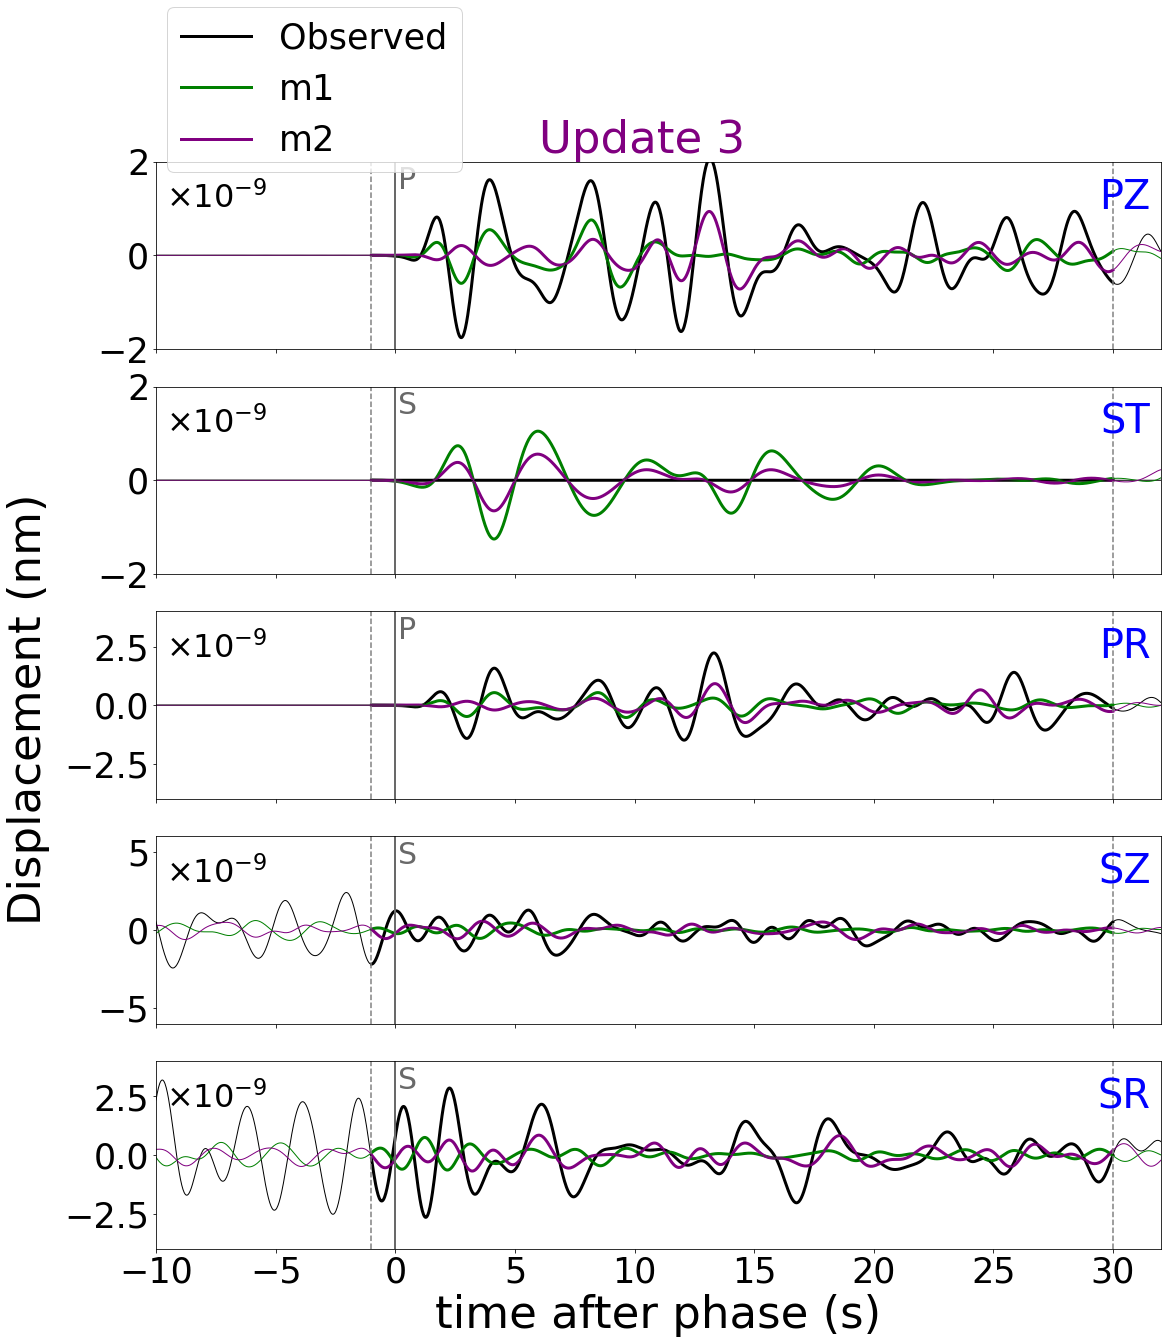

In [54]:
fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))
for i, (tr_obs, tr_m0, tr_m1) in enumerate(zip(st_obs_w, st_m0_w, st_m1_w)):
    ax[i].plot(
        tr_obs.times() - t_pres[i], tr_obs.data, lw=3, c="k", label="Observed",
    )
    ax[i].plot(
        tr_m0.times() - t_pres[i], tr_m0.data, lw=3, c="g", label="m1",
    )
    ax[i].plot(
        tr_m1.times() - t_pres[i], tr_m1.data, lw=3, c="purple", label="m2",
    )
for i, (tr_obs, tr_m0, tr_m1) in enumerate(zip(st_obs_full, st_m0_full, st_m1_full)):
    ax[i].plot(
        tr_obs.times() - obs_tts[i], tr_obs.data, lw=1, c="k",
    )
    ax[i].plot(
        tr_m0.times() - m0_tts[i], tr_m0.data, lw=1, c="g",
    )
    ax[i].plot(
        tr_m1.times() - m1_tts[i], tr_m1.data, lw=1, c="purple",
    )

    ax[i].text(
        s=f"{phases[i]}{comps[i]}",
        x=0.99,
        y=0.75,
        ha="right",
        transform=ax[i].transAxes,
        color="blue",
        fontsize=40,
    )
    ax[i].tick_params(axis="both", which="major", labelsize=35)
    ax[i].get_yaxis().get_offset_text().set_visible(False)
    ax_max = max(ax[i].get_yticks())
    exponent_axis = np.floor(np.log10(ax_max)).astype(int)
    ax[i].annotate(
        r"$\times$10$^{%i}$" % (exponent_axis),
        xy=(0.01, 0.75),
        xycoords="axes fraction",
        fontsize=32,
    )
    if ylims is None:
        global_max = max([tr.data.max() for tr in st_obs_w]) * 1.2
        global_min = min([tr.data.min() for tr in st_obs_w]) * 1.2
        ax[i].set_ylim(global_min, global_max)
    else:
        ax[i].set_ylim(-ylims[i], ylims[i])
    ymax = ax[i].get_ylim()[1]
    ax[i].axvline(x=t_posts[i], c="grey", ls="dashed")
    ax[i].axvline(x=-t_pres[i], c="grey", ls="dashed")
    ax[i].axvline(x=0.0, c="dimgrey", lw=2)
    ax[i].text(
        0 + 0.1,
        ymax * 0.8,
        phases[i],
        verticalalignment="center",
        color="dimgray",
        fontsize=30,
    )

fig.text(0.01, 0.5, "Displacement (nm)", va="center", rotation="vertical", fontsize=45)
fig.text(
    0.5,
    0.88,
    "Update 3",
    ha="center",
    va="bottom",
    size="x-large",
    color="purple",
    fontsize=45,
)

ax[0].legend(
    prop={"size": 35},
    loc="center left",
    bbox_to_anchor=(0.12, 0.93),
    bbox_transform=fig.transFigure,
)

ax[-1].set_xlim(-10.0, 32.0)
ax[-1].set_xlabel("time after phase (s)", fontsize=45)

# Try BFGS:

In [ ]:
from scipy.optimize import minimize

In [56]:
res = minimize(
    src_str.misfit,
    m0,
    st_obs_w,
    method="BFGS",
    options={"maxiter": 2, "eps": eps_array, "return_all": True, "gtol": 1e-8, "disp":True},
)

array([  1.60693719e-01,   2.71984752e-01,  -4.00000000e-01,
        -4.22179427e-02,   2.93333141e-01,   7.70484821e-01,
         7.00019649e+01])